# Big Data – Exercises - Solutions

# Fall 2021 -  Week 11 - Rumble



# 1. Install Rumble

### Option 1: Docker
The first option is to run RumbleDB in a docker container with everything installed, open docker on your computer and run the following command on your command line. Note that where you run the command does not matter as it fetches a remote docker image:
```
docker run -i rumbledb/rumble --shell yes
```

This will open a shell where you can play around with rumble.

Make sure to periodically run ```docker pull rumbledb/rumble``` to fetch newer versions.


### Option 2: Locally
To install the latest version of RumbleDB locally, you can follow the steps given on the official rumbledb website: 
https://rumble.readthedocs.io/en/latest/Getting%20started/

Please follow very carefully the instructions, in particular, first install Spark and check that `spark-submit --version` works before proceeding with RumbleDB. Also mind the Java version as it is guaranteed that it will not work with Java 17.

We strongly recommend using Spark 3.1, the corresponding jar is available here: https://github.com/RumbleDB/rumble/releases/download/v1.16.2/rumbledb-1.16.2-for-spark-3.1.jar. You can download the jar and put it into the exercise session repository.

Note: This new RumbleDB version was released on 09.12.21 and fixes recursive cycle 'input' issues that some experienced.

Now that you have everything needed, you can test your installation by runnning the following command
```
spark-submit rumbledb-1.16.2-for-spark-3.1.jar --shell yes
```

This gives access to the RumbleDB shell where you can try commands. Note that to run each command, you should press 'Enter' three times, and you can quit with 'exit'. 





Feel free to try the many functions available, here is a link with the exhaustive list: https://rumble.readthedocs.io/en/latest/Function%20library/.

# 2. Setup Rumble in Jupyter Notebook



### Install Jupyter Notebook



In order to execute the queries in this notebook, you need to [install](https://jupyter.org/install) jupyter notebook on your **own machine**, and then download this notebook and [run](https://jupyter.readthedocs.io/en/latest/running.html#running) it locally rather than rely on the colab.

To get started, you first need to execute the cell below to activate the Rumble magic (you do not need to understand what it does, this is just initialization Python code).

In [2]:
import requests
import json
import time
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def rumble(line, cell=None):
    if cell is None:
        data = line
    else:
        data = cell

    start = time.time()                                                         
    response = json.loads(requests.post(server, data=data).text)                   
    end = time.time()                                                              
    print("Took: %s s" % (end - start))

    if 'warning' in response:
        print(json.dumps(response['warning']))
    if 'values' in response:
        for e in response['values']:
            print(json.dumps(e))
    elif 'error-message' in response:
        return response['error-message']
    else:
        return response

From now we want to run the code on the notebook instead of the shell, hence you can close the shell (Ctrl+C or type 'exit') and execute your own Rumble server by running:

If you did the local installation
```
spark-submit rumbledb-1.16.2-for-spark-3.1.jar --server yes --port 8001
```

If you did the docker installation
```
docker run -p 8001:8001 --rm -it --mount type=bind,source=replace-with-path-to-exercise11-folder,target=/home  rumbledb/rumble --server yes --port 8001 --host 0.0.0.0 
```

The mount allows RumbleDB to directly read the files from your local disk. If you use Docker, make sure to update the path to `"/home/confusion-2014-03-02/confusion-2014-03-02.json"` in `json-file` calls.

Running the command tells you on which port your server is running  on line
**`[INFO] Starting Rumble in server mode on port ...`** 

<img src="https://cloud.inf.ethz.ch/s/xPZQpYm676dZopf/download" width="60%">

In [3]:
server = 'http://localhost:8001/jsoniq'

Now we are all set! You can now start reading and executing the JSONiq queries in this notebook as you go, and you can even edit them!

# 3. Rumble Sandbox

## JSON

As explained on the [official JSON Web site](http://www.json.org/), JSON is a lightweight data-interchange format designed for humans as well as for computers. It supports as values:
- objects (string-to-value maps)
- arrays (ordered sequences of values)
- strings
- numbers
- booleans (true, false)
- null

JSONiq provides declarative querying and updating capabilities on JSON data.

## Elevator Pitch

JSONiq is based on XQuery, which is a W3C standard (like XML and HTML). XQuery is a very powerful declarative language that originally manipulates XML data, but it turns out that it is also a very good fit for manipulating JSON natively.
JSONiq, since it extends XQuery, is a very powerful general-purpose declarative programming language. Our experience is that, for the same task, you will probably write about 80% less code compared to imperative languages like JavaScript, Python or Ruby. Additionally, you get the benefits of strong type checking without actually having to write type declarations.
Here is an appetizer before we start the tutorial from scratch.


In [3]:
%%rumble

let $stores :=
[
  { "store number" : 1, "state" : "MA" },
  { "store number" : 2, "state" : "MA" },
  { "store number" : 3, "state" : "CA" },
  { "store number" : 4, "state" : "CA" }
]
let $sales := [
   { "product" : "broiler", "store number" : 1, "quantity" : 20  },
   { "product" : "toaster", "store number" : 2, "quantity" : 100 },
   { "product" : "toaster", "store number" : 2, "quantity" : 50 },
   { "product" : "toaster", "store number" : 3, "quantity" : 50 },
   { "product" : "blender", "store number" : 3, "quantity" : 100 },
   { "product" : "blender", "store number" : 3, "quantity" : 150 },
   { "product" : "socks", "store number" : 1, "quantity" : 500 },
   { "product" : "socks", "store number" : 2, "quantity" : 10 },
   { "product" : "shirt", "store number" : 3, "quantity" : 10 }
]
let $join :=
  for $store in $stores[], $sale in $sales[]
  where $store."store number" = $sale."store number"
  return {
    "nb" : $store."store number",
    "state" : $store.state,
    "sold" : $sale.product
  }
return [$join]

Took: 1.006300926208496 s
[{"nb": 1, "state": "MA", "sold": "broiler"}, {"nb": 1, "state": "MA", "sold": "socks"}, {"nb": 2, "state": "MA", "sold": "toaster"}, {"nb": 2, "state": "MA", "sold": "toaster"}, {"nb": 2, "state": "MA", "sold": "socks"}, {"nb": 3, "state": "CA", "sold": "toaster"}, {"nb": 3, "state": "CA", "sold": "blender"}, {"nb": 3, "state": "CA", "sold": "blender"}, {"nb": 3, "state": "CA", "sold": "shirt"}]


## And here you go

### Actually, you already knew some JSONiq

The first thing you need to know is that a well-formed JSON document is a JSONiq expression as well.
This means that you can copy-and-paste any JSON document into a query. The following are JSONiq queries that are "idempotent" (they just output themselves):

In [4]:
%%rumble
{ "pi" : 3.14, "sq2" : 1.4 }

Took: 0.04699397087097168 s
{"pi": 3.14, "sq2": 1.4}


In [5]:
%%rumble
[ 2, 3, 5, 7, 11, 13 ]

Took: 0.02355790138244629 s
[2, 3, 5, 7, 11, 13]


In [6]:
%%rumble
{
      "operations" : [
        { "binary" : [ "and", "or"] },
        { "unary" : ["not"] }
      ],
      "bits" : [
        0, 1
      ]
    }

Took: 0.025409936904907227 s
{"operations": [{"binary": ["and", "or"]}, {"unary": ["not"]}], "bits": [0, 1]}


In [7]:
%%rumble
[ { "Question" : "Ultimate" }, ["Life", "the universe", "and everything"] ]

Took: 0.03923606872558594 s
[{"Question": "Ultimate"}, ["Life", "the universe", "and everything"]]



This works with objects, arrays (even nested), strings, numbers, booleans, null.

It also works the other way round: if your query outputs an object or an array, you can use it as a JSON document. JSONiq is a declarative language. This means that you only need to say what you want - the compiler will take care of the how.

In the above queries, you are basically saying: I want to output this JSON content, and here it is.

## JSONiq basics

### The real JSONiq Hello, World!

Wondering what a hello world program looks like in JSONiq? Here it is:

In [8]:
%%rumble
"Hello, World!"

Took: 0.02448892593383789 s
"Hello, World!"


Not surprisingly, it outputs the string "Hello, World!".

### Numbers and arithmetic operations

Okay, so, now, you might be thinking: "What is the use of this language if it just outputs what I put in?" Of course, JSONiq can more than that. And still in a declarative way. Here is how it works with numbers:

In [9]:
%%rumble
2 + 2

Took: 0.031881093978881836 s
4


In [10]:
%%rumble
 (38 + 2) div 2 + 11 * 2


Took: 0.03168892860412598 s
42


(mind the division operator which is the "div" keyword. The slash operator has different semantics).

Like JSON, JSONiq works with decimals and doubles:

In [11]:
%%rumble
 6.022e23 * 42

Took: 0.03443789482116699 s
2.52924e+25


### Logical operations

JSONiq supports boolean operations.

In [12]:
%%rumble
true and false

Took: 0.026146888732910156 s
false


In [13]:
%%rumble
(true or false) and (false or true)

Took: 0.024437904357910156 s
true


The unary not is also available:

In [14]:
%%rumble
not true

Took: 0.024089813232421875 s
false


### Strings

JSONiq is capable of manipulating strings as well, using functions:


In [15]:
%%rumble
concat("Hello ", "Captain ", "Kirk")

Took: 0.1690840721130371 s
"Hello Captain Kirk"


In [16]:
%%rumble
substring("Mister Spock", 8, 5)

Took: 0.019188880920410156 s
"Spock"


JSONiq comes up with a rich string function library out of the box, inherited from its base language. These functions are listed [here](https://www.w3.org/TR/xpath-functions-30/) (actually, you will find many more for numbers, dates, etc).



### Sequences

Until now, we have only been working with single values (an object, an array, a number, a string, a boolean). JSONiq supports sequences of values. You can build a sequence using commas:


In [17]:
%%rumble
 (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)

Took: 0.02513885498046875 s
1
2
3
4
5
6
7
8
9
10


In [18]:
%%rumble
1, true, 4.2e1, "Life"

Took: 0.024859189987182617 s
1
true
42
"Life"


The "to" operator is very convenient, too:

In [19]:
%%rumble
 (1 to 100)

Took: 0.02121114730834961 s
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


Some functions even work on sequences:

In [20]:
%%rumble
sum(1 to 100)

Took: 0.02873969078063965 s
5050


In [21]:
%%rumble
string-join(("These", "are", "some", "words"), "-")

Took: 0.020885944366455078 s
"These-are-some-words"


In [22]:
%%rumble
count(10 to 20)

Took: 0.0316319465637207 s
11


In [23]:
%%rumble
avg(1 to 100)

Took: 0.02544713020324707 s
50.5


Unlike arrays, sequences are flat. The sequence (3) is identical to the integer 3, and (1, (2, 3)) is identical to (1, 2, 3).

## A bit more in depth

### Variables

You can bind a sequence of values to a (dollar-prefixed) variable, like so:

In [24]:
%%rumble
let $x := "Bearing 3 1 4 Mark 5. "
return concat($x, "Engage!")

Took: 0.021946191787719727 s
"Bearing 3 1 4 Mark 5. Engage!"


In [25]:
%%rumble
let $x := ("Kirk", "Picard", "Sisko")
return string-join($x, " and ")

Took: 0.02002406120300293 s
"Kirk and Picard and Sisko"


You can bind as many variables as you want:

In [26]:
%%rumble
let $x := 1
let $y := $x * 2
let $z := $y + $x
return ($x, $y, $z)

Took: 0.02782917022705078 s
1
2
3


and even reuse the same name to hide formerly declared variables:

In [27]:
%%rumble
let $x := 1
let $x := $x + 2
let $x := $x + 3
return $x

Took: 0.030309200286865234 s
6


### Iteration

In a way very similar to let, you can iterate over a sequence of values with the "for" keyword. Instead of binding the entire sequence of the variable, it will bind each value of the sequence in turn to this variable.

In [28]:
%%rumble
for $i in 1 to 10
return $i * 2

Took: 0.01728677749633789 s
2
4
6
8
10
12
14
16
18
20


More interestingly, you can combine fors and lets like so:

In [29]:
%%rumble
let $sequence := 1 to 10
for $value in $sequence
let $square := $value * 2
return $square

Took: 0.03367185592651367 s
2
4
6
8
10
12
14
16
18
20


and even filter out some values:

In [30]:
%%rumble
let $sequence := 1 to 10
for $value in $sequence
let $square := $value * 2
where $square < 10
return $square

Took: 0.027679920196533203 s
2
4
6
8


Note that you can only iterate over sequences, not arrays. To iterate over an array, you can obtain the sequence of its values with the [] operator, like so:


In [31]:
%%rumble
[1, 2, 3][]

Took: 0.021741151809692383 s
1
2
3


### Conditions

You can make the output depend on a condition with an if-then-else construct:

In [32]:
%%rumble
for $x in 1 to 10
return if ($x < 5) then $x
                   else -$x

Took: 0.026714086532592773 s
1
2
3
4
-5
-6
-7
-8
-9
-10


Note that the else clause is required - however, it can be the empty sequence () which is often when you need if only the then clause is relevant to you.

### Composability of Expressions

Now that you know of a couple of elementary JSONiq expressions, you can combine them in more elaborate expressions. For example, you can put any sequence of values in an array:

In [33]:
%%rumble
[ 1 to 10 ]

Took: 0.018603086471557617 s
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


Or you can dynamically compute the value of object pairs (or their key):

In [34]:
%%rumble
{
      "Greeting" : (let $d := "Mister Spock"
                    return concat("Hello, ", $d)),
      "Farewell" : string-join(("Live", "long", "and", "prosper"),
                               " ")
}

Took: 0.01826190948486328 s
{"Greeting": "Hello, Mister Spock", "Farewell": "Live long and prosper"}


You can dynamically generate object singletons (with a single pair):


In [35]:
%%rumble
{ concat("Integer ", 2) : 2 * 2 }

Took: 0.02002096176147461 s
{"Integer 2": 4}


and then merge lots of them into a new object with the {| |} notation:

In [36]:
%%rumble
{|
    for $i in 1 to 10
    return { concat("Square of ", $i) : $i * $i }
|}

Took: 0.024817943572998047 s
{"Square of 1": 1, "Square of 2": 4, "Square of 3": 9, "Square of 4": 16, "Square of 5": 25, "Square of 6": 36, "Square of 7": 49, "Square of 8": 64, "Square of 9": 81, "Square of 10": 100}


## JSON Navigation

Up to now, you have learnt how to compose expressions so as to do some computations and to build objects and arrays. It also works the other way round: if you have some JSON data, you can access it and navigate.
All you need to know is: JSONiq views
an array as an ordered list of values,
an object as a set of name/value pairs


### Objects

You can use the dot operator to retrieve the value associated with a key. Quotes are optional, except if the key has special characters such as spaces. It will return the value associated thereto:

In [37]:
%%rumble
let $person := {
    "first name" : "Sarah",
    "age" : 13,
    "gender" : "female",
    "friends" : [ "Jim", "Mary", "Jennifer"]
}
return $person."first name"

Took: 0.017603158950805664 s
"Sarah"


You can also ask for all keys in an object:

In [38]:
%%rumble
let $person := {
    "name" : "Sarah",
    "age" : 13,
    "gender" : "female",
    "friends" : [ "Jim", "Mary", "Jennifer"]
}
return { "keys" : [ keys($person)] }

Took: 0.024400711059570312 s
{"keys": ["name", "age", "gender", "friends"]}


### Arrays

The [[]] operator retrieves the entry at the given position:

In [39]:
%%rumble
let $friends := [ "Jim", "Mary", "Jennifer"]
return $friends[[1+1]]

Took: 0.021285057067871094 s
"Mary"


It is also possible to get the size of an array:

In [40]:
%%rumble
let $person := {
    "name" : "Sarah",
    "age" : 13,
    "gender" : "female",
    "friends" : [ "Jim", "Mary", "Jennifer"]
}
return { "how many friends" : size($person.friends) }

Took: 0.02326512336730957 s
{"how many friends": 3}


Finally, the [] operator returns all elements in an array, as a sequence:

In [41]:
%%rumble
let $person := {
    "name" : "Sarah",
    "age" : 13,
    "gender" : "female",
    "friends" : [ "Jim", "Mary", "Jennifer"]
}
return $person.friends[]

Took: 0.04448819160461426 s
"Jim"
"Mary"
"Jennifer"


### Relational Algebra

Do you remember SQL's SELECT FROM WHERE statements? JSONiq inherits selection, projection and join capability from XQuery, too.

In [42]:
%%rumble
let $stores :=
[
    { "store number" : 1, "state" : "MA" },
    { "store number" : 2, "state" : "MA" },
    { "store number" : 3, "state" : "CA" },
    { "store number" : 4, "state" : "CA" }
]
let $sales := [
    { "product" : "broiler", "store number" : 1, "quantity" : 20  },
    { "product" : "toaster", "store number" : 2, "quantity" : 100 },
    { "product" : "toaster", "store number" : 2, "quantity" : 50 },
    { "product" : "toaster", "store number" : 3, "quantity" : 50 },
    { "product" : "blender", "store number" : 3, "quantity" : 100 },
    { "product" : "blender", "store number" : 3, "quantity" : 150 },
    { "product" : "socks", "store number" : 1, "quantity" : 500 },
    { "product" : "socks", "store number" : 2, "quantity" : 10 },
    { "product" : "shirt", "store number" : 3, "quantity" : 10 }
]
let $join :=
    for $store in $stores[], $sale in $sales[]
    where $store."store number" = $sale."store number"
    return {
        "nb" : $store."store number",
        "state" : $store.state,
        "sold" : $sale.product
    }
return [$join]

Took: 0.04973316192626953 s
[{"nb": 1, "state": "MA", "sold": "broiler"}, {"nb": 1, "state": "MA", "sold": "socks"}, {"nb": 2, "state": "MA", "sold": "toaster"}, {"nb": 2, "state": "MA", "sold": "toaster"}, {"nb": 2, "state": "MA", "sold": "socks"}, {"nb": 3, "state": "CA", "sold": "toaster"}, {"nb": 3, "state": "CA", "sold": "blender"}, {"nb": 3, "state": "CA", "sold": "blender"}, {"nb": 3, "state": "CA", "sold": "shirt"}]


### Access datasets

Rumble can read input from many file systems and many file formats. If you are using our backend, you can only use json-doc() with any URI pointing to a JSON file and navigate it as you see fit. 

In [43]:
%%rumble
json-doc("Put any HTTP URL pointing to a JSON document here!").foo[[1]].bar.foobar[]

Took: 0.02882099151611328 s


'There was an error on line 1 in file:/Users/pierre/Documents/ex11/:\n\njson-doc("Put any HTTP URL pointing to a JSON document here!").foo[[1]].bar.foobar[]\n^\n\nCode: [FODC0002]\nMessage: Malformed URI: Put any HTTP URL pointing to a JSON document here! Cause: Illegal character in path at index 3: Put any HTTP URL pointing to a JSON document here!\nMetadata: file:/Users/pierre/Documents/ex11/:LINE:1:COLUMN:0:\nThis code can also be looked up in the documentation and specifications for more information.\n'

If you are using your own Rumble server on your cluster, you can also use any other function and scheme.

In [44]:
%%rumble
json-file("put the path to a JSON lines file here. This will only work against your own Rumble backend and Spark cluster, though.")

Took: 0.03588676452636719 s


'There was an error on line 1 in file:/Users/pierre/Documents/ex11/:\n\njson-file("put the path to a JSON lines file here. This will only work against your own Rumble backend and Spark cluster, though.")\n^\n\nCode: [FODC0002]\nMessage: File file:/Users/pierre/Documents/ex11/put%20the%20path%20to%20a%20JSON%20lines%20file%20here.%20This%20will%20only%20work%20against%20your%20own%20Rumble%20backend%20and%20Spark%20cluster,%20though. not found.\nMetadata: file:/Users/pierre/Documents/ex11/:LINE:1:COLUMN:0:\nThis code can also be looked up in the documentation and specifications for more information.\n'

# 4. The Great Language Game

This week you will be using again the [language confusion dataset](http://lars.yencken.org/datasets/languagegame/). You will write queries with Rumble. You will have to submit the results of this exercise to Moodle to obtain the weekly bonus. You will need these things:
- The query you wrote
- Something related to its output (which you will be graded on)
- The time it took you to run it

The execution time of the queries will be reported by Rumble.

Download and decompress the dataset in the same folder as `rumbledb-1.16.0.jar` with the following:
```
wget http://data.greatlanguagegame.com.s3.amazonaws.com/confusion-2014-03-02.tbz2
tar -jxvf confusion-2014-03-02.tbz2
```
or, if wget command is not found,
```
curl -o confusion-2014-03-02.tbz2 http://data.greatlanguagegame.com.s3.amazonaws.com/confusion-2014-03-02.tbz2
tar -jxvf confusion-2014-03-02.tbz2
```

Afterwards, you should a folder with a (large) json file inside.

## 4.0 Check the data

We provide you with two datasets, you can already check that you get the correct number of records. The full dataset should contain 16511224 records. We also provided you with a second small dataset to test your queries faster, it contains 100000 records.

In [24]:
%%rumble
count(for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json")
return $i)

Took: 9.04823613166809 s
16511224


In [23]:
%%rumble
count(for $i in json-file("confusion-100000.json")
return $i)

Took: 0.27375006675720215 s
100000


## 4.1 Query the data

You can read data from a json file with `json-file`. For example, the following query will read and print the entries in the confusion dataset:




In [45]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json")
return $i

Took: 82.74304270744324 s
"Warning! The output sequence contains 16511224 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"guess": "Norwegian", "target": "Norwegian", "country": "AU", "choices": ["Maori", "Mandarin", "Norwegian", "Tongan"], "sample": "48f9c924e0d98c959d8a6f1862b3ce9a", "date": "2013-08-19"}
{"guess": "Dinka", "target": "Dinka", "country": "AU", "choices": ["Danish", "Dinka", "Khmer", "Lao"], "sample": "af5e8f27cef9e689a070b8814dcc02c3", "date": "2013-08-19"}
{"guess": "Turkish", "target": "Samoan", "country": "AU", "choices": ["German", "Hungarian", "Samoan", "Turkish"], "sample": "509c36eb58dbce009ccf93f375358d53", "date": "2013-08-19"}
{"guess": "Latvian", "target": "Somali", "country": "AU", "choices": ["Danish", "Korean", "Latvian", "Somali"], "sample": "a505ab771ae7c32744ad31b3051b8ee9", "date": "2013-08-19"}
{"guess": "Japanese", "target": "Japanese", "co

After the results of your query are printed, Rumble will report the execution runtime in milliseconds:
```
Took: 62.02618598937988 ms
```

In the `json-file` method you can optionally specify the number of partitions, which may allow your query to be parallelized and executed faster. This offers great advantage on cluster, but is not much faster locally. For example:


In [71]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
return $i

Took: 57.696205139160156 s
"Warning! The output sequence contains 16511224 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"guess": "Norwegian", "target": "Norwegian", "country": "AU", "choices": ["Maori", "Mandarin", "Norwegian", "Tongan"], "sample": "48f9c924e0d98c959d8a6f1862b3ce9a", "date": "2013-08-19"}
{"guess": "Dinka", "target": "Dinka", "country": "AU", "choices": ["Danish", "Dinka", "Khmer", "Lao"], "sample": "af5e8f27cef9e689a070b8814dcc02c3", "date": "2013-08-19"}
{"guess": "Turkish", "target": "Samoan", "country": "AU", "choices": ["German", "Hungarian", "Samoan", "Turkish"], "sample": "509c36eb58dbce009ccf93f375358d53", "date": "2013-08-19"}
{"guess": "Latvian", "target": "Somali", "country": "AU", "choices": ["Danish", "Korean", "Latvian", "Somali"], "sample": "a505ab771ae7c32744ad31b3051b8ee9", "date": "2013-08-19"}
{"guess": "Japanese", "target": "Japanese", "c

## 4.2 SQL to Rumble

The following examples, show how SQL queries can be converted to JSONiq queries. Assume that the dataset is accessible with SQL through the table "entries".





### 4.2.1 Get all games played from Switzerland


```sql
SELECT *
FROM entries
WHERE country == "CH"
```


In [47]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
where $i.country eq "CH"
return $i

Took: 67.26994919776917 s
"Warning! The output sequence contains 135347 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"guess": "Amharic", "target": "Amharic", "country": "CH", "choices": ["Amharic", "Dari"], "sample": "9b1340b8343bb267783e1bfb2dc55bf1", "date": "2013-09-01"}
{"guess": "Korean", "target": "Korean", "country": "CH", "choices": ["Burmese", "Korean"], "sample": "0f8e6818d2be77b75712bc9ea4e87171", "date": "2013-09-01"}
{"guess": "Thai", "target": "Thai", "country": "CH", "choices": ["Farsi", "Thai"], "sample": "74b5340a230b1e0c1d45787bc4280b05", "date": "2013-09-01"}
{"guess": "Finnish", "target": "Hungarian", "country": "CH", "choices": ["Finnish", "German", "Hungarian"], "sample": "cb1a1c1c93ab6e802560855ca5f015f7", "date": "2013-09-01"}
{"guess": "Russian", "target": "Russian", "country": "CH", "choices": ["Czech", "Japanese", "Russian"], "sample": "b7df3f9d67c

### 4.2.2 Get all games played from Switzerland, where the correct answer (target) was "German"
```sql
SELECT *
FROM entries
WHERE country == "CH" AND target == "German"
```




In [48]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
where $i.country eq "CH" and $i.target eq "German"
return $i

Took: 72.98781085014343 s
"Warning! The output sequence contains 2684 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"guess": "German", "target": "German", "country": "CH", "choices": ["German", "Spanish"], "sample": "1f8b9a59cd75fc429db54dceb6e0594b", "date": "2013-09-02"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["Dari", "German"], "sample": "e77d97b712adffc39e531e20237a5589", "date": "2013-09-03"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["Dari", "German", "Vietnamese"], "sample": "78213fa858b9a45d83121a8bf71712d1", "date": "2013-09-03"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["French", "German", "Norwegian", "Thai"], "sample": "e77d97b712adffc39e531e20237a5589", "date": "2013-09-03"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["German", "Lao"], "sample": "e77d97b712a

### 4.2.3 Get the top 5 games played from Switzerland, where the correct answer (target) was "German"
```sql
SELECT *
FROM entries
WHERE country == "CH" AND target == "German"
LIMIT 5
```




In [49]:
%%rumble
let $ch-de_data := for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    where $i.country eq "CH" and $i.target eq "German"
    return $i
for $j in $ch-de_data
count $c
where $c <= 5
return $j

Took: 78.40956807136536 s
{"guess": "German", "target": "German", "country": "CH", "choices": ["German", "Spanish"], "sample": "1f8b9a59cd75fc429db54dceb6e0594b", "date": "2013-09-02"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["Dari", "German"], "sample": "e77d97b712adffc39e531e20237a5589", "date": "2013-09-03"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["Dari", "German", "Vietnamese"], "sample": "78213fa858b9a45d83121a8bf71712d1", "date": "2013-09-03"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["French", "German", "Norwegian", "Thai"], "sample": "e77d97b712adffc39e531e20237a5589", "date": "2013-09-03"}
{"guess": "German", "target": "German", "country": "CH", "choices": ["German", "Lao"], "sample": "e77d97b712adffc39e531e20237a5589", "date": "2013-09-03"}


### 4.2.4 Get all games played from Switzerland, where the correct answer (target) was "German", order them by date (ascending), and return the top 5 rows.
```sql
SELECT *
FROM entries
WHERE country == "CH" AND target == "German"
ORDER BY date ASC
LIMIT 5
```




In [4]:
%%rumble
let $ch-de_data := for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    order by $i.date ascending
    return $i
for $j in $ch-de_data
count $c
where $c <= 5
return $j

Took: 33.89351677894592 s
{"guess": "Norwegian", "target": "Norwegian", "country": "AU", "choices": ["Maori", "Mandarin", "Norwegian", "Tongan"], "sample": "48f9c924e0d98c959d8a6f1862b3ce9a", "date": "2013-08-19"}
{"guess": "Dinka", "target": "Dinka", "country": "AU", "choices": ["Danish", "Dinka", "Khmer", "Lao"], "sample": "af5e8f27cef9e689a070b8814dcc02c3", "date": "2013-08-19"}
{"guess": "Turkish", "target": "Samoan", "country": "AU", "choices": ["German", "Hungarian", "Samoan", "Turkish"], "sample": "509c36eb58dbce009ccf93f375358d53", "date": "2013-08-19"}
{"guess": "Latvian", "target": "Somali", "country": "AU", "choices": ["Danish", "Korean", "Latvian", "Somali"], "sample": "a505ab771ae7c32744ad31b3051b8ee9", "date": "2013-08-19"}
{"guess": "Japanese", "target": "Japanese", "country": "AU", "choices": ["Bangla", "Dinka", "Italian", "Japanese"], "sample": "3569611136ea04bab18a0cd605ced358", "date": "2013-08-19"}


### 4.2.5 Get all games played from Switzerland, where the correct answer (target) was "German", group them by date, and return for each different date the number of games played.

```sql
SELECT date, COUNT(*) AS num_games
FROM entries
WHERE country == "CH" AND target == "German"
GROUP BY date
```


In [51]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
where $i.country eq "CH" and $i.target eq "German"
group by $d := $i.date
return {"date": $d, "num_games": count($i)}

Took: 81.36013889312744 s
{"date": "2013-09-20", "num_games": 16}
{"date": "2013-09-23", "num_games": 3}
{"date": "2013-11-23", "num_games": 12}
{"date": "2013-12-06", "num_games": 5}
{"date": "2013-12-09", "num_games": 2}
{"date": "2013-09-19", "num_games": 13}
{"date": "2013-12-30", "num_games": 11}
{"date": "2014-02-28", "num_games": 24}
{"date": "2013-10-04", "num_games": 1}
{"date": "2013-09-09", "num_games": 32}
{"date": "2014-02-18", "num_games": 17}
{"date": "2013-10-30", "num_games": 5}
{"date": "2014-02-01", "num_games": 2}
{"date": "2013-09-29", "num_games": 10}
{"date": "2014-02-12", "num_games": 32}
{"date": "2014-02-11", "num_games": 47}
{"date": "2013-09-15", "num_games": 41}
{"date": "2014-02-05", "num_games": 2}
{"date": "2013-11-22", "num_games": 7}
{"date": "2013-11-28", "num_games": 9}
{"date": "2013-11-02", "num_games": 2}
{"date": "2013-11-11", "num_games": 2}
{"date": "2013-11-10", "num_games": 7}
{"date": "2013-09-18", "num_games": 23}
{"date": "2013-10-19", "nu

### 4.2.6 Get all games played from Switzerland, group them by date and target, and return for each different date and target the number of games played.


NOTE: Rumble has some reserved keywords, for example `date`. If you try to create a variable `$date`, you may get an error, such as `no viable alternative at input 'date'`.

```sql
SELECT date, target, COUNT(*) AS num_games
FROM entries
WHERE country == "CH"
GROUP BY date, target
```




In [52]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
where $i.country eq "CH"
group by $d := $i.date, $target := $i.target
return {"date": $d, "target": $target, "num_games": count($i)}


Took: 70.45219206809998 s
"Warning! The output sequence contains 12449 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"date": "2013-09-02", "target": "Indonesian", "num_games": 3}
{"date": "2013-09-03", "target": "Croatian", "num_games": 16}
{"date": "2013-09-03", "target": "Indonesian", "num_games": 13}
{"date": "2013-09-04", "target": "Macedonian", "num_games": 93}
{"date": "2013-09-10", "target": "Greek", "num_games": 35}
{"date": "2013-09-11", "target": "Latvian", "num_games": 20}
{"date": "2013-09-15", "target": "Amharic", "num_games": 15}
{"date": "2013-09-17", "target": "Thai", "num_games": 24}
{"date": "2013-09-19", "target": "Amharic", "num_games": 6}
{"date": "2013-09-25", "target": "Korean", "num_games": 8}
{"date": "2013-09-29", "target": "Central Tibetan", "num_games": 9}
{"date": "2013-09-30", "target": "Arabic", "num_games": 6}
{"date": "2013-09-30", "target": "

### 4.2.7 For all games played from Switzerland, return the distinct targets of those games.

```sql
SELECT DISTINCT(target)
FROM entries
WHERE country == "CH"
```




In [53]:
%%rumble
let $targets := for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
  where $i.country eq "CH"
  return $i.target
return distinct-values($targets)

Took: 62.7044780254364 s
"Albanian"
"Ukrainian"
"Dutch"
"Vietnamese"
"Basque"
"Indonesian"
"Welsh"
"Burmese"
"Fijian"
"Samoan"
"Hebrew"
"Latvian"
"Macedonian"
"Northern Sami"
"Dari"
"Bangla"
"Central Tibetan"
"Norwegian"
"Polish"
"Thai"
"Swedish"
"Slovak"
"Danish"
"Czech"
"Khmer"
"Lao"
"Malay"
"Maori"
"Tamil"
"Finnish"
"Urdu"
"Romanian"
"Tagalog"
"Bosnian"
"Greek"
"Estonian"
"Hungarian"
"Kannada"
"Dinka"
"Tongan"
"Mandarin"
"Armenian"
"Maltese"
"Yiddish"
"Italian"
"Bulgarian"
"French"
"South Efate"
"Farsi"
"Gujarati"
"Portuguese"
"Punjabi"
"Icelandic"
"German"
"Slovenian"
"Northern Ndebele"
"Kurdish"
"Russian"
"Swahili"
"Korean"
"Hindi"
"Malayalam"
"Japanese"
"Assyrian"
"Amharic"
"Arabic"
"Serbian"
"Nepali"
"Spanish"
"Shona"
"Cantonese"
"Somali"
"Croatian"
"Sinhalese"
"Scottish Gaelic"
"Hausa"
"Tigrinya"
"Turkish"


### 4.2.8 For all games played from Switzerland, get the distinct targets of those games, and return the index of "German" in the list of distinct targets.




In [54]:
%%rumble
let $targets := for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    where $i.country eq "CH"
    return $i.target
return index-of(distinct-values($targets), "German")


Took: 62.42255520820618 s
54


### 4.2.9 Count the number of games played from Switzerland (without any grouping).


NOTE: `distinct-values` and `index-of` work on "sequences". The method `json-file` returns a sequence. If you have an array on which you want to apply `distinct-values` and `index-of`, you must first convert it to a sequence. This can be done with `[]`. For example, if you have an array called `arr`, you can find its distinct values with `distinct-values(arr[])`

```sql
SELECT COUNT(*) AS count
FROM entries
WHERE country == "CH"
```


In [55]:
%%rumble
count(for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    where $i.country eq "CH"
    return $i
)

Took: 63.41305589675903 s
135347


If in your query you want to join 2 (or more) sequences (results of `json-file` or subqueries), you can do it in the following way:
```
let $seq1 := ...
let $seq2 := ...
for $i in $seq1, $j in $seq2
where $i.attr1 eq $j.attr2
...
```

## 4.3 More queries

Try writing a few more queries:
- List all chosen answers to games where the guessed language is correct (=target).

In [56]:
%%rumble
distinct-values(
    for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    where $i.target eq $i.guess
    return $i.guess
)

Took: 81.97674226760864 s
"Albanian"
"Ukrainian"
"Dutch"
"Vietnamese"
"Basque"
"Indonesian"
"Welsh"
"Burmese"
"Fijian"
"Samoan"
"Hebrew"
"Latvian"
"Macedonian"
"Northern Sami"
"Dari"
"Bangla"
"Central Tibetan"
"Norwegian"
"Polish"
"Thai"
"Swedish"
"Slovak"
"Danish"
"Czech"
"Khmer"
"Lao"
"Malay"
"Maori"
"Tamil"
"Finnish"
"Urdu"
"Romanian"
"Tagalog"
"Bosnian"
"Greek"
"Estonian"
"Hungarian"
"Kannada"
"Dinka"
"Tongan"
"Mandarin"
"Armenian"
"Maltese"
"Yiddish"
"Italian"
"Bulgarian"
"French"
"South Efate"
"Farsi"
"Gujarati"
"Portuguese"
"Punjabi"
"Icelandic"
"German"
"Slovenian"
"Northern Ndebele"
"Kurdish"
"Russian"
"Swahili"
"Korean"
"Hindi"
"Malayalam"
"Japanese"
"Assyrian"
"Amharic"
"Arabic"
"Serbian"
"Nepali"
"Spanish"
"Shona"
"Cantonese"
"Somali"
"Croatian"
"Sinhalese"
"Scottish Gaelic"
"Hausa"
"Tigrinya"
"Turkish"


- Count the games where the index of the correct answer in the choices array is 2 (as returned by the index-of method).

In [57]:
%%rumble
count(
    for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    where index-of($i.choices[], $i.target) eq 2
    return $i
)

Took: 81.76744604110718 s
6008820


- Return all games played on February 3rd 2014.

In [58]:
%%rumble
for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
where $i.date eq "2014-02-03"
return $i

Took: 220.43723678588867 s
"Warning! The output sequence contains 38940 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"guess": "Kurdish", "target": "Kurdish", "country": "CA", "choices": ["Kurdish", "Romanian"], "sample": "6c50f5972917a1ab11328233ef50db72", "date": "2014-02-03"}
{"guess": "Norwegian", "target": "Danish", "country": "CA", "choices": ["Danish", "Norwegian"], "sample": "99cbb382f36c87a89d8169de36e4414d", "date": "2014-02-03"}
{"guess": "Assyrian", "target": "Dari", "country": "CA", "choices": ["Assyrian", "Dari"], "sample": "f8c25418c2675fa8c3278aa7a21678f6", "date": "2014-02-03"}
{"guess": "Slovak", "target": "Slovak", "country": "CA", "choices": ["Farsi", "Slovak"], "sample": "c8f4c9a5c3a919644b8a3e8fa2407d7d", "date": "2014-02-03"}
{"guess": "Italian", "target": "Italian", "country": "CA", "choices": ["Italian", "Welsh"], "sample": "465d54ddd2b1237d3cbd359dbf

# 5. More nestedness
## 5.1 Create Nestedness
You may remember in the exercise of Spark Dataframes & Spark SQL, we mentioned two methods <font face="courier">collect_set/collect_list</font> for creating arrays. In JSONiq, this kind of things become even simpler because JSONiq natively supports JSON, so we can directly create arrays via adding square brackets (<font face="courier">[]</font>) and even without any group by operations. 

For example, if we want to know the list of date at which "Fijian" was used as the target, we can write a simple JSONiq query:

In [6]:
%%rumble
let $dateSeq := for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
    where $i.target eq "Fijian"
    return $i.date
return [subsequence($dateSeq, 0, 10)]

Took: 14.561774969100952 s
["2013-08-19", "2013-08-19", "2013-08-19", "2013-08-20", "2013-08-20", "2013-08-20", "2013-08-20", "2013-08-20", "2013-08-20"]


Note: We used the RumbleDB subsequence function documented here (https://rumble.readthedocs.io/en/latest/Function%20library/#subsequence) to bypass materialization limitations of arrays.

The above query is basically a counterpart of a Spark Dataframe query with <font face="courier">collect_list</font>. If we want to imitate the behavior of <font face="courier">collect_set</font>, which means we want the result array to be de-duplicated, we can just resort to <font face="courier">distinct-values</font>:

In [60]:
%%rumble
let $dateSeq := for $i in json-file("confusion-2014-03-02/confusion-2014-03-02.json", 10)
where $i.target eq "Fijian"
return $i.date
return [distinct-values($dateSeq)]

Took: 62.66869401931763 s
["2014-01-10", "2014-01-11", "2013-10-10", "2013-09-20", "2014-01-12", "2014-01-13", "2013-10-11", "2013-09-21", "2013-09-22", "2013-10-12", "2014-01-14", "2013-10-13", "2014-01-15", "2013-09-23", "2013-09-24", "2014-01-16", "2013-10-14", "2014-02-01", "2013-09-25", "2013-10-15", "2014-01-17", "2014-02-02", "2013-10-16", "2014-01-18", "2013-09-26", "2014-01-19", "2014-02-03", "2013-11-01", "2013-09-27", "2013-10-17", "2013-11-02", "2013-09-28", "2013-10-18", "2014-02-04", "2014-02-05", "2013-10-19", "2013-09-29", "2013-11-03", "2014-02-06", "2013-11-04", "2014-02-07", "2013-11-05", "2013-11-06", "2014-02-08", "2013-11-30", "2014-02-09", "2013-11-07", "2013-11-08", "2013-11-09", "2013-12-20", "2013-12-21", "2013-12-22", "2013-12-23", "2013-12-24", "2013-12-25", "2013-12-26", "2013-12-27", "2013-09-01", "2013-12-28", "2013-12-29", "2013-09-02", "2013-09-03", "2013-08-19", "2014-01-20", "2013-09-04", "2014-01-21", "2013-09-05", "2014-01-22", "2013-09-06", "2013-0

Now what if we want to know for each different language, the de-duplicated list of date at which it was used as a target? We may need group by again. Try to come up with the query on your own. What might be the difference in the query with and without group by?

**Note:** Do not hesitate to only use the small provided dataset because the query on the original dataset might take very long and consume a humongous amount of memory. The most important thing is not about the answer, but to come up with proper queries.

In [61]:
%%rumble
for $i in json-file("confusion-100000.json", 10) 
group by $j := $i.target
return {"language":$j, "dates":[distinct-values($i.date)]}

Took: 121.87912702560425 s
{"language": "Cantonese", "dates": ["2013-08-19", "2013-08-20", "2013-08-21", "2013-08-23", "2013-08-26", "2013-08-29", "2013-08-31", "2013-09-01", "2013-09-02", "2013-09-03"]}
{"language": "Sinhalese", "dates": ["2013-08-19", "2013-08-20", "2013-08-21", "2013-08-22", "2013-08-23", "2013-08-26", "2013-08-28", "2013-09-01", "2013-09-02", "2013-09-03"]}
{"language": "Portuguese", "dates": ["2013-08-19", "2013-08-20", "2013-08-21", "2013-08-23", "2013-08-25", "2013-08-26", "2013-08-29", "2013-09-01", "2013-09-02", "2013-09-03"]}
{"language": "Swedish", "dates": ["2013-08-19", "2013-08-20", "2013-08-21", "2013-08-22", "2013-08-23", "2013-08-25", "2013-08-26", "2013-08-29", "2013-09-01", "2013-09-02", "2013-09-03"]}
{"language": "Tagalog", "dates": ["2013-08-19", "2013-08-20", "2013-08-21", "2013-08-22", "2013-08-23", "2013-08-24", "2013-08-25", "2013-08-26", "2013-08-28", "2013-08-29", "2013-09-01", "2013-09-02", "2013-09-03"]}
{"language": "Slovak", "dates": ["2

The difference is, if there's group by in a query, after group by, the loop variable (\$i in the above query) will no longer be a single entry, but instead bound to the **sequence** corresponding to each group, which means we can directly apply functions like distinct-values to \$i.
In the query above without group by, \$i always corresponds to one entry, so there's no point to do things like distinct-values(\$i.date). This is why we need to get the intermediate result $dataSeq, and then create arrays and apply distinct-values on this whole sequence.

Obviously, unlike <font face="courier">collect_set/collect_list</font> which only accept one column and create arrays on that very column, JSONiq can create arrays on arbitrary things. For example, if we want to highlight the information of date, we can create a new dataset that shows the game info for each date:

In [72]:
%%rumble
let $newDataset := for $i in in json-file("confusion-100000.json", 10) 
  group by $d := $i.date
  return {"date": $d, "info": [$i]}
return $newDataset

Took: 112.7034821510315 s
{"date": "2013-08-25", "info": [{"guess": "Bosnian", "target": "Tigrinya", "country": "AU", "choices": ["Bosnian", "Kannada", "Romanian", "Tigrinya"], "sample": "3ec316c78773bb826dd924926f5c0d07", "date": "2013-08-25"}, {"guess": "Swedish", "target": "Swedish", "country": "AU", "choices": ["Korean", "Lao", "Swedish", "Turkish"], "sample": "dfe8192c1bbd80b44ea4409d9889dc90", "date": "2013-08-25"}, {"guess": "Greek", "target": "Greek", "country": "AU", "choices": ["Dinka", "Greek", "Korean", "Maltese"], "sample": "d6f08d099e6f753b96ede3d475d25106", "date": "2013-08-25"}, {"guess": "Kurdish", "target": "Kurdish", "country": "AU", "choices": ["Kurdish", "Mandarin", "Slovak", "Tigrinya"], "sample": "9f849ff225f0d94a52c186924e225231", "date": "2013-08-25"}, {"guess": "Indonesian", "target": "Swahili", "country": "AU", "choices": ["Arabic", "Croatian", "Indonesian", "Swahili"], "sample": "d720bf82f29b3f6d835a4f7dcb9c2dcb", "date": "2013-08-25"}, {"guess": "Bosnian", 

Now we have a more nested dataset! We can try to redo some of the exercises above with this new dataset. For example, get all games played in Switzerland:

In [73]:
%%rumble
let $newDataset := for $i in in json-file("confusion-100000.json", 10) 
  group by $d := $i.date
  return {"date": $d, "info": [$i]}
for $j in $newDataset.info[]
where $j.country eq "CH"
return $j

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Took: 116.39802193641663 s
"Warning! The output sequence contains 308 items but its materialization was capped at 200 items. This value can be configured with the result-size parameter in the query string of the HTTP request."
{"guess": "Amharic", "target": "Amharic", "country": "CH", "choices": ["Amharic", "Dari"], "sample": "9b1340b8343bb267783e1bfb2dc55bf1", "date": "2013-09-01"}
{"guess": "Korean", "target": "Korean", "country": "CH", "choices": ["Burmese", "Korean"], "sample": "0f8e6818d2be77b75712bc9ea4e87171", "date": "2013-09-01"}
{"guess": "Thai", "target": "Thai", "country": "CH", "choices": ["Farsi", "Thai"], "sample": "74b5340a230b1e0c1d45787bc4280b05", "date": "2013-09-01"}
{"guess": "Finnish", "target": "Hungarian", "country": "CH", "choices": ["Finnish", "German", "Hungarian"], "sample": "cb1a1c1c93ab6e802560855ca5f015f7", "date": "2013-09-01"}
{"guess": "Russian", "target": "Russian", "country": "CH", "choices": ["Czech", "Japanese", "Russian"], "sample": "b7df3f9d67cef

Try another one: get the count of games played in Switzerland:

In [75]:
%%rumble
count(
  let $newDataset := for $i in in json-file("confusion-100000.json", 10) 
    group by $d := $i.date
    return {"date": $d, "info": [$i]}
  for $j in $newDataset.info[]
  where $j.country eq "CH"
  return $j
)

Took: 115.24654197692871 s
308


Feel free to try out more questions on your own!

## 5.2 Git-archive dataset
Now let's get into the mess of the real world. We are going to explore the git-archive dataset to handle some properly messy data, which is very challenging if you use Spark. 

For getting the dataset, just run:
```
wget https://polybox.ethz.ch/index.php/s/HVWlvJAXVkQ05cw/download -O git-archive.json
```
or use curl as done for the great game language dataset.

Have a look at what the dataset looks like:

In [7]:
%%rumble
for $i in json-file("git-archive.json", 10)
count $c
where $c <= 1
return $i

Took: 1.1095619201660156 s
{"id": "7045118886", "type": "PushEvent", "actor": {"id": 20090775, "login": "lainrose", "display_login": "lainrose", "gravatar_id": "", "url": "https://api.github.com/users/lainrose", "avatar_url": "https://avatars.githubusercontent.com/u/20090775?"}, "repo": {"id": 115387592, "name": "lainrose/Python-Grammar", "url": "https://api.github.com/repos/lainrose/Python-Grammar"}, "payload": {"push_id": 2226161589, "size": 1, "distinct_size": 1, "ref": "refs/heads/master", "head": "27a01fbdbec8e26daa40fc8faa052dd0be23836a", "before": "d6fce97b8de28a31d021c9a9f7ac939baa14d208", "commits": [{"sha": "27a01fbdbec8e26daa40fc8faa052dd0be23836a", "author": {"name": "lainrose", "email": "fb4676bf30682e2ece361fd363a69ad11779c42e@Naver.com"}, "message": "Update Study Contents", "distinct": true, "url": "https://api.github.com/repos/lainrose/Python-Grammar/commits/27a01fbdbec8e26daa40fc8faa052dd0be23836a"}]}, "public": true, "created_at": "2018-01-01T15:00:00Z"}


What a mess, isn't it? Anyway, let's try to write some challenging queries, since you've already mastered those easy ones with the language game dataset...

1. What is the number of distinct author names that are part of a push event (i.e., an event with the type PushEvent)?

In [43]:
%%rumble
let $seq := for $e in json-file("git-archive.json", 10)
where $e."type" eq "PushEvent"
return $e.payload.commits[].author.name
return count(distinct-values($seq))

Took: 0.26726317405700684 s
10134


2. What is the name of the repository with the highest number of push events (i.e., events with the type PushEvent), and how many of these push events occurred in this repository?

In [40]:
%%rumble
for $e in json-file("git-archive.json", 10)
where $e."type" eq "PushEvent"
group by $d := $e.repo.name
order by count($e) descending
count $c
where $c <= 1
return {"name": $d, "push events received": count($e)}

Took: 1.673750877380371 s
{"name": "shenzhouzd/update", "push events received": 190}


## BONUS: Machine Learning in Rumble

Not only RumbleDB allows to build the entire data pipeline by querying large messy datasets and clean, structure, normoalize and validate them but now also supports feeding the data into machine learning models to build an all-in-one solution. RumbleDB uses Spark to distribute computations accross a cluster, and for ML it is also based on the SparkML library (https://spark.apache.org/docs/latest/ml-guide.html). Here is a simple example to clusterize data points based on a KMeans model.

In the following example we declare a user defined type col-1-2 with an id and two decimal columns. We then write our data in a variable local-data, which we validate against our defined type and then forward the data to a transformer. Finally, we instantiate a K-means estimator to train our data on it.

In [44]:
%%rumble
declare type local:col-1-2 as {
  "id": "integer",
  "col1": "decimal",
  "col2": "decimal"
};

let $vector-assembler := get-transformer("VectorAssembler")(
  ?,
  { "inputCols" : [ "col1", "col2" ], "outputCol" : "features" }
)

let $local-data := (
    {"id": 0, "col1": 0.0, "col2": 3.0},
    {"id": 1, "col1": 2.1, "col2": 0.1},
    {"id": 2, "col1": 0.2, "col2": 0.2},
    {"id": 3, "col1": 6.0, "col2": 9.0},
    {"id": 4, "col1": 5.1, "col2": 9.1},
    {"id": 5, "col1": 9.2, "col2": 9.2}
)
let $df-data := validate type local:col-1-2* {$local-data }
let $df-data := $vector-assembler($df-data)

let $est := get-estimator("KMeans")
let $tra := $est(
    $df-data,
    {"featuresCol": "features"}
)

for $i in $tra(
    $df-data,
    {"featuresCol": "features"}
)
return $i

Took: 0.7687070369720459 s
{"id": 0, "col1": 0, "col2": 3, "features": [0, 3], "prediction": 0}
{"id": 1, "col1": 2.1, "col2": 0.1, "features": [2.1, 0.1], "prediction": 0}
{"id": 2, "col1": 0.2, "col2": 0.2, "features": [0.2, 0.2], "prediction": 0}
{"id": 3, "col1": 6, "col2": 9, "features": [6, 9], "prediction": 1}
{"id": 4, "col1": 5.1, "col2": 9.1, "features": [5.1, 9.1], "prediction": 1}
{"id": 5, "col1": 9.2, "col2": 9.2, "features": [9.2, 9.2], "prediction": 1}


### Visualize the output

   id  col1  col2  prediction
0   0   0.0   3.0           0
1   1   2.1   0.1           0
2   2   0.2   0.2           0
3   3   6.0   9.0           1
4   4   5.1   9.1           1
5   5   9.2   9.2           1


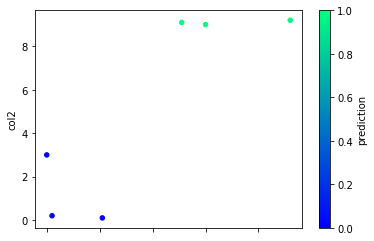

In [45]:
import pandas as pd

d = [{"id": 0, "col1": 0.0, "col2": 3.0, "prediction": 0},
    {"id": 1, "col1": 2.1, "col2": 0.1, "prediction": 0},
    {"id": 2, "col1": 0.2, "col2": 0.2, "prediction": 0},
    {"id": 3, "col1": 6.0, "col2": 9.0, "prediction": 1},
    {"id": 4, "col1": 5.1, "col2": 9.1, "prediction": 1},
    {"id": 5, "col1": 9.2, "col2": 9.2, "prediction": 1}]

df = pd.DataFrame(d)
print (df)

ax1 = df.plot.scatter(x='col1',
                      y='col2',
                      c='prediction', cmap='winter')

## Bonus: Run rumble on a Spark cluster in Azure

In this last bonus, we will take advantage of a main aspect of RumbleDB, to be runnable on clusters.

### Create a cluster

1. Sign into the azure portal (portal.azure.com).
1. Search for "HDInsight clusters" using the search box at the top.
<img src="https://cloud.inf.ethz.ch/s/WxpMXB3Jz8SykMw/download" width="900">
1. Note that under the *Subscription* section, you might be prompted that the subscription is not registered:
<img src="https://cloud.inf.ethz.ch/s/gyTcQYKFCn3Yg6J/download" width="500">

  To fix this, follow the *Click here to register* link, and in the new page, search for *hdinsight*. Then select the *Microsoft.HDInsight* Provider and click the *Register* button.  
<img src="https://cloud.inf.ethz.ch/s/oHn9eyeZRP4LfZq/download" width="500">

1. Create a new resource group (for example: 'exercise08').
1. Give the cluster a unique name.
1. In the "Cluster Type" choose **Spark** and leave the default version as is. It is also indicated to use the **US West** region. 
1. Create a cluster login password (you can use https://www.random.org/strings/ for inspiration). Keep the password around as you will need it for later.
<img src="https://cloud.inf.ethz.ch/s/JY3DRLg8NLH559K/download" width="900">
1. Move to the *Storage* stage of the setup. Here, leave **Azure Storage** as the *Primary Storage Type*. For the *Primary Storage Account* you have the option to set up a new account. The *Container*'s name will be generated automatically, however make sure to remember it, or change it to something memorable, if you plan on finishing the exercises in more than one sitting.
<img src="https://cloud.inf.ethz.ch/s/NgtHE6iwSCZ8FQi/download" width="900">
1. Move to the *Configuration + Pricing* stage of the setup (skip *Security + networking*). Set up a Spark cluster which uses 2 **A5**  deployments as *Head* nodes and 2 **D12 v2** deployments for the *Worker* nodes. It should cost roughly 1.9 EUR/h. Note that if Azure allows you deploy more cores, then do so, by increasing the number of *Worker* nodes.
<img src="https://cloud.inf.ethz.ch/s/JpJEfjkZLPja5EK/download" width="900">
1. Move to the *Reivew + Create* stage of the setup, and click the **Create** button once validation succeeds.
1. Wait until your cluster is deployed (this can take up to 20 minutes).

<span style="color: red;">**Important:** Remember to **delete** the cluster once you are done. If you want to stop doing the exercises at any point, delete it and recreate it using the same container name as you used the first time, so that the resources are still there.</span>

<img src="https://cloud.inf.ethz.ch/s/2jLERoTD6q8nRMQ/download" width="900">

### Access your cluster

Make sure you can access your cluster (the NameNode) via SSH:

```
$ ssh <ssh_user_name>@<cluster_name>-ssh.azurehdinsight.net
```

If you are using Linux or MacOSX, you can use your standard terminal.
If you are using Windows you can use:
- Putty SSH Client and PSCP tool (get them at [here](http://www.chiark.greenend.org.uk/~sgtatham/putty/download.html)).
- This Notebook server terminal (Click on the Jupyter logo and the goto New -> Terminal).
- Azure Cloud Terminal (see the HBase exercise sheet for details)

You can access cluster's YARN in your browser
```
 https://<cluster_name>.azurehdinsight.net/yarnui/hn/cluster
```


## Install Rumble

Then login to the shell and download the latest Rumble version:

```
wget https://github.com/RumbleDB/rumble/releases/download/v1.16.2/rumbledb-1.16.2-for-spark-2.4.jar
```

### HDInsight Shell

Unfortunately HDInsight will not provide us access to any other port than SSH.
Therefore the usual way to work with Rumble through HDInsight is through the shell.

### SSH Forwarding

Howeever for this sheet, we recommend to use SSH forwarding. For that, run:

```
spark-submit rumbledb-1.16.2-for-spark-2.4.jar --server yes --port 8002
```

and then on your local machine forward 8002 -> localhost:8002

```
ssh -N -L 8002:localhost:8002 sshuser@[servername]-ssh.azurehdinsight.net
```

Run the code from your notebook on the cluster and evaluate the speed improvement.